In [ ]:
import numpy as np
import pandas as pd
import datetime
import math
import os
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# DL library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Reshape, GRU, RNN, Flatten, Input, TimeDistributed, RepeatVector

tf.keras.backend.set_floatx('float64')

In [ ]:
kepcoTotal_data = pd.read_csv('./kepcoTotal.csv', encoding='cp949')

In [ ]:
print(kepcoTotal_data.shape)

(69408, 2)


In [ ]:
kepcoTotal_data

,Hourly Time,Hourly Sum
0,2015년 10월 01일 00시,557904.3242
1,2015년 10월 01일 01시,537670.6250
2,2015년 10월 01일 02시,524698.2930
3,2015년 10월 01일 03시,517785.5781
4,2015년 10월 01일 04시,518839.8789
...,...,...
69403,2023년 08월 31일 19시,835083.0391
69404,2023년 08월 31일 20시,801076.7617
69405,2023년 08월 31일 21시,763438.7461
69406,2023년 08월 31일 22시,742240.2422


## Preprocess data

In [ ]:
# 한국 1시간당 전력 데이터 -> datatime type으로 변환
kepcoTotal_data['Hourly Time'] = pd.to_datetime(kepcoTotal_data['Hourly Time'], format='%Y년 %m월 %d일 %H시')
kepcoTotal_data

,Hourly Time,Hourly Sum
0,2015-10-01 00:00:00,557904.3242
1,2015-10-01 01:00:00,537670.6250
2,2015-10-01 02:00:00,524698.2930
3,2015-10-01 03:00:00,517785.5781
4,2015-10-01 04:00:00,518839.8789
...,...,...
69403,2023-08-31 19:00:00,835083.0391
69404,2023-08-31 20:00:00,801076.7617
69405,2023-08-31 21:00:00,763438.7461
69406,2023-08-31 22:00:00,742240.2422


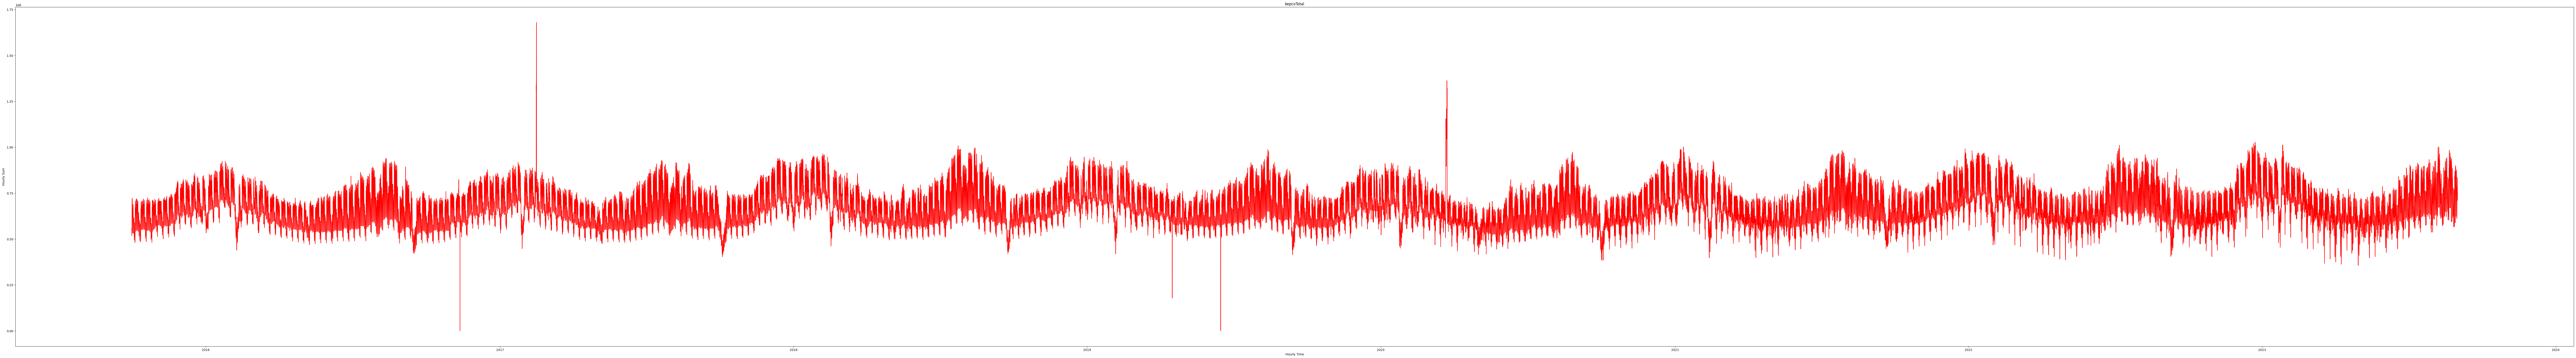

In [ ]:
# 한국 1시간당 전력 데이터 -> 그래프 생성
plt.figure(figsize=(150,20))
plt.plot(kepcoTotal_data['Hourly Time'],kepcoTotal_data['Hourly Sum'],color='red',linestyle='-')

# 그래프 정보 설정
plt.xlabel('Hourly Time') # x 라벨
plt.ylabel('Hourly Sum') # y 라벨
plt.title("kepcoTotal") # 그래프 이름

# 그래프 출력
plt.show()

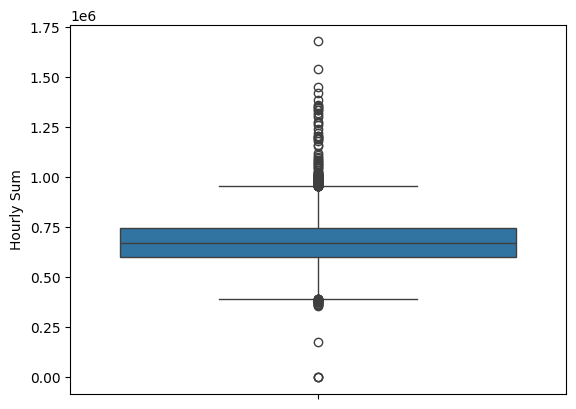

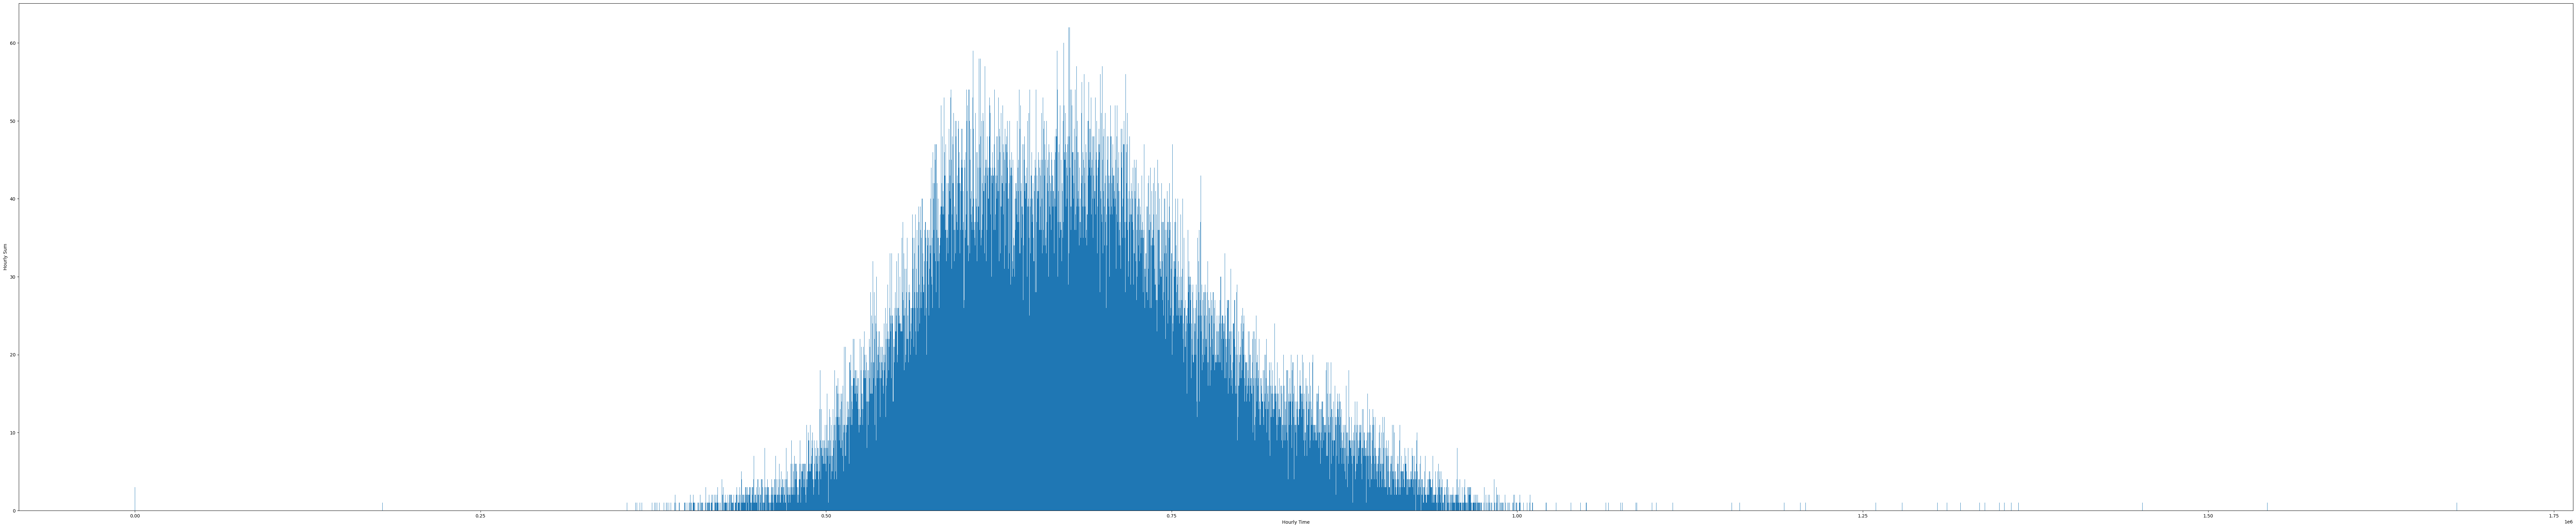

In [ ]:
# 한국 1시간당 전력 데이터
import seaborn as sns
sns.boxplot(y='Hourly Sum', data = kepcoTotal_data)

plt.figure(figsize=(100,20))
plt.hist(kepcoTotal_data['Hourly Sum'], 10000)
plt.xlabel('Hourly Time') # x 라벨
plt.ylabel('Hourly Sum') # y 라벨
plt.show()

In [ ]:
Q1 = kepcoTotal_data['Hourly Sum'].quantile(0.25)
Q3 = kepcoTotal_data['Hourly Sum'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
# 이상치 대체
median = kepcoTotal_data['Hourly Sum'].median()
kepcoTotal_data.loc[(kepcoTotal_data['Hourly Sum'] < lower_bound) | (kepcoTotal_data['Hourly Sum'] > upper_bound), 'Hourly Sum'] = median

<Axes: ylabel='Hourly Sum'>

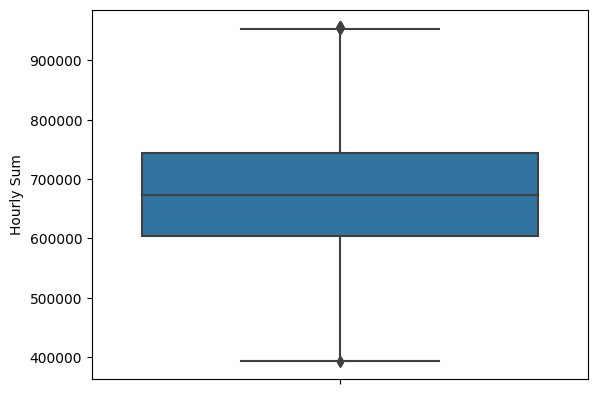

In [ ]:
import seaborn as sns
sns.boxplot(y='Hourly Sum', data = kepcoTotal_data)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
kepcoTotal_data['Hourly Sum'] = scaler.fit_transform(kepcoTotal_data[['Hourly Sum']])

## Train Model

dataset 정의


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

def create_dataset(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [ ]:
window_size = 24
dataset = kepcoTotal_data['Hourly Sum'].values
dataset = dataset.reshape(-1,1)
X, y = create_dataset(dataset, window_size)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

split = int(len(X) * 0.7)
trainX, remainX = X[:split], X[split:]
trainY, remainY = y[:split], y[split:]

split2 = int(len(remainX) * 0.5)
testX, valX = remainX[:split2], remainX[split2:]
testY, valY = remainY[:split2], remainY[split2:]

모델 정의


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 24, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (239.46 KB)
Trainable params: 30651 (239.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.01)

model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(trainX, trainY, epochs=30, batch_size=32, validation_data=(valX, valY), callbacks=[early_stopping])

Epoch 1/30
1518/1518 [==============================] - 22s 9ms/step - loss: 0.0662 - val_loss: 0.1104
Epoch 2/30
1518/1518 [==============================] - 14s 9ms/step - loss: 0.0495 - val_loss: 0.1072
Epoch 3/30
1518/1518 [==============================] - 13s 8ms/step - loss: 0.0432 - val_loss: 0.1107
Epoch 4/30
1518/1518 [==============================] - 13s 8ms/step - loss: 0.0405 - val_loss: 0.1021
Epoch 5/30
1518/1518 [==============================] - 13s 8ms/step - loss: 0.0381 - val_loss: 0.0967
Epoch 6/30
1518/1518 [==============================] - 13s 8ms/step - loss: 0.0370 - val_loss: 0.0911
Epoch 7/30
1518/1518 [==============================] - 13s 8ms/step - loss: 0.0355 - val_loss: 0.0946
Epoch 8/30
1518/1518 [==============================] - 13s 8ms/step - loss: 0.0348 - val_loss: 0.0934
Epoch 9/30
1518/1518 [==============================] - 13s 8ms/step - loss: 0.0338 - val_loss: 0.0920
Epoch 10/30
1518/1518 [==============================] - 13s 8ms/step - l

## Evaluation with TEST SET

In [ ]:
predictions = model.predict(testX)
predictions = predictions.reshape(testY.shape)
mape = np.mean(np.abs((testY - predictions) / testY)) * 100
r2 = r2_score(testY, predictions)
mae = mean_absolute_error(testY, predictions)
rmse = np.sqrt(mean_squared_error(testY, predictions))
mmae = np.mean(np.abs((testY - predictions) / testY))

# 성능 지표 계산
print("MAPE:", mape)
print("R2 Score:", r2)
print("MAE:", mae)
print("RMSE:", rmse)
print("mMAE:", mmae)

326/326 [==============================] - 3s 4ms/step
MAPE: 240.63032489604464
R2 Score: 0.8883008440511193
MAE: 0.23752518099587291
RMSE: 0.34170490783386825
mMAE: 2.4063032489604463


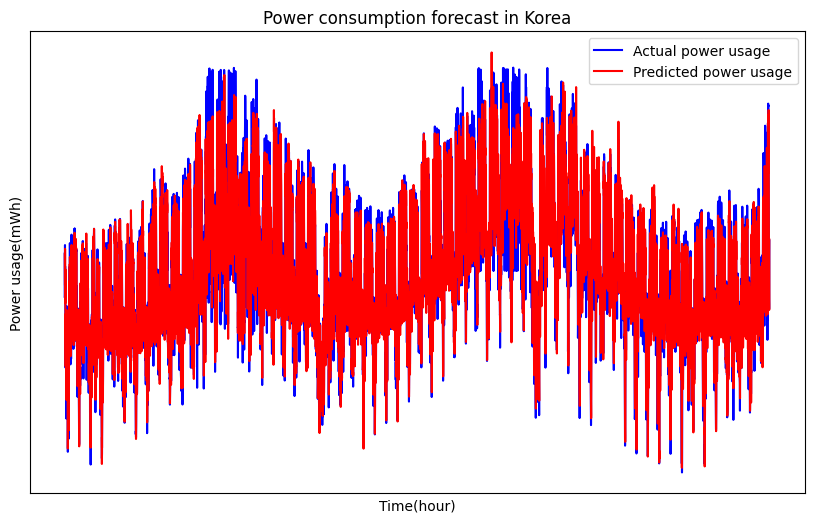

In [ ]:
# GT value(blue) VS predicted value(red)
plt.figure(figsize=(10, 6))
plt.plot(testY, label='Actual power usage', color='blue')
plt.plot(predictions, label='Predicted power usage', color='red')
plt.title('Power consumption forecast in Korea')
plt.xlabel('Time(hour)')
plt.ylabel('Power usage(mWh)')
plt.yscale('linear')
plt.xticks([], [])
plt.yticks([], [])
plt.legend()

plt.show()